In [19]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, HalvingRandomSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import uniform, randint, loguniform

# prog bar
from tqdm.autonotebook import tqdm
from tqdm_joblib import tqdm_joblib

# out of space in ssd
import os

temp_dir = r"F:\tempFolder"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
    print(f"Folder created: {temp_dir}")
else:
    print(f"Folder already exists: {temp_dir}")

os.environ["JOBLIB_TEMP_FOLDER"] = temp_dir

Folder already exists: F:\tempFolder


In [14]:
df = pd.read_csv('output_data/data_with_nearest_mrt.csv')

df.head(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,latitude,longitude,nearest_mrt,distance_km
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1.364329,103.844110,NS16 Ang Mo Kio MRT,0.8583
1,1990-01-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1.322221,103.866576,DT24 Geylang Bahru MRT,0.5667
2,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1.324647,103.863076,NE9 Boon Keng MRT,0.5406
3,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1.300282,103.884178,TE24 Katong Park MRT,0.4427
4,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1.315145,103.850806,NE8 Farrer Park MRT,0.5137
5,1990-01-01,KALLANG/WHAMPOA,3 ROOM,49,DORSET RD,04 TO 06,68.0,NEW GENERATION,1979,52000.0,1.312795,103.850025,NE8 Farrer Park MRT,0.5208
6,1990-01-01,KALLANG/WHAMPOA,3 ROOM,95,GEYLANG BAHRU,13 TO 15,68.0,NEW GENERATION,1979,61000.0,1.322874,103.870867,DT24 Geylang Bahru MRT,0.1781
7,1990-01-01,KALLANG/WHAMPOA,3 ROOM,94,GEYLANG BAHRU,04 TO 06,68.0,NEW GENERATION,1979,61000.0,1.322688,103.871334,DT24 Geylang Bahru MRT,0.1403
8,1990-01-01,KALLANG/WHAMPOA,3 ROOM,16,UPP BOON KENG RD,04 TO 06,65.0,IMPROVED,1975,42000.0,1.315592,103.871855,EW10 Kallang MRT,0.4599
9,1990-01-01,KALLANG/WHAMPOA,3 ROOM,68,GEYLANG BAHRU,16 TO 18,65.0,IMPROVED,1974,45700.0,1.322333,103.870043,DT24 Geylang Bahru MRT,0.2002


In [ ]:
# preprocess

# Create new features (more to be added maybe)
df['flat_age'] = 2025 - df['lease_commence_date']

target = 'resale_price'
features = [
    'town',
    'flat_type',
    'storey_range',
    'floor_area_sqm',
    'flat_model',
    'flat_age',
    'street_name',
    'nearest_mrt',
    'distance_km'
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

categorical_features = ['town', 'flat_type', 'storey_range', 'flat_model', 'street_name', 'nearest_mrt']
numerical_features = ['floor_area_sqm', 'flat_age', 'distance_km']

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

In [16]:
# Define eval metrics

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nModel Evaluation Metrics:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE):      {mae:.2f}")
    print(f"R² Score:                       {r2:.4f}")

    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
    print("Cross-validated R² scores:", cv_scores)
    print("Mean CV R²:", cv_scores.mean())

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.show()


Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 99530.28
Mean Absolute Error (MAE):      79853.64
R² Score:                       0.6804
Cross-validated R² scores: [0.68196826 0.68240438 0.68094426]
Mean CV R²: 0.6817723001275783


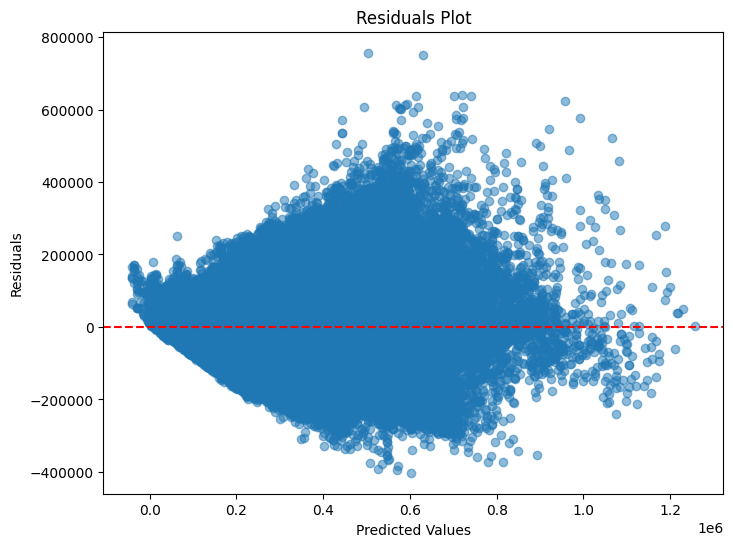

In [ ]:
# Base linear regression (baseline)

pipeline_base = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_base.fit(X_train, y_train)
y_pred_base = pipeline_base.predict(X_test)
evaluate_model(pipeline_base, X_test, y_test)

RandomizedSearchCV:   0%|          | 0/11 [00:00<?, ?iter/s]

  0%|          | 0/11 [00:00<?, ?it/s]

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 6
max_resources_: 25000
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 4166
n_resources: 6
Fitting 3 folds for each of 4166 candidates, totalling 12498 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


----------
iter: 1
n_candidates: 1389
n_resources: 18
Fitting 3 folds for each of 1389 candidates, totalling 4167 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.38730035 0.41431149 0.37282014]
  warnings.warn(


----------
iter: 2
n_candidates: 463
n_resources: 54
Fitting 3 folds for each of 463 candidates, totalling 1389 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.45329718 0.45258805 0.45312302]
  warnings.warn(


----------
iter: 3
n_candidates: 155
n_resources: 162
Fitting 3 folds for each of 155 candidates, totalling 465 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.57564244 0.57538198 0.57536954]
  warnings.warn(


----------
iter: 4
n_candidates: 52
n_resources: 486
Fitting 3 folds for each of 52 candidates, totalling 156 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.57896057 0.58030231 0.57984926]
  warnings.warn(


----------
iter: 5
n_candidates: 18
n_resources: 1458
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.6153806  0.61533381 0.61522534]
  warnings.warn(


----------
iter: 6
n_candidates: 6
n_resources: 4374
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.64284453 0.64286966 0.64288978]
  warnings.warn(


----------
iter: 7
n_candidates: 2
n_resources: 13122
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.64288978 0.66770047 0.66769928]
  warnings.warn(


Best parameters: {'preprocessor__num__poly__degree': 1, 'preprocessor__num__poly__interaction_only': True, 'regressor': Ridge(), 'regressor__alpha': 5.818725208663576}
Best cross-validated R²: 0.6677004707281248
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['floor_area_sqm', 'flat_age',
                                                

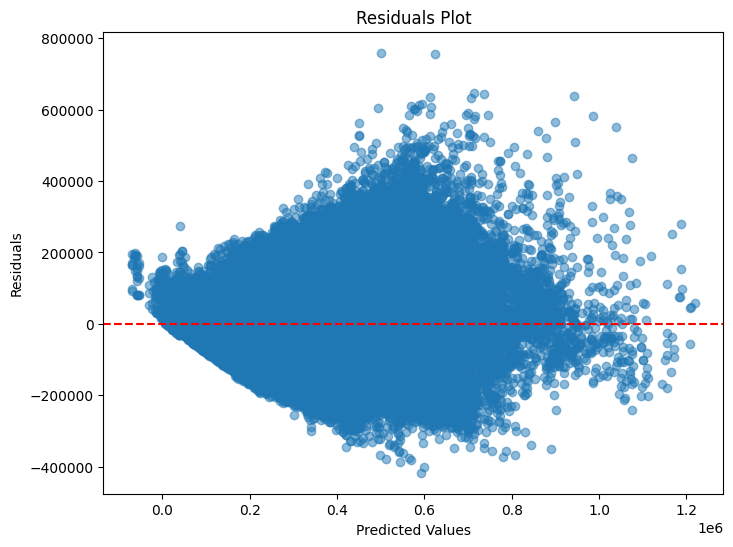

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Hyperparameter tuning
param_distributions = {
    'regressor': [Ridge(), Lasso(), ElasticNet()],
    'regressor__alpha': loguniform(0.1, 100.0),
    'preprocessor__num__poly__degree': [1, 2],  # 1 = no extra interactions, 2 adds them
    'preprocessor__num__poly__interaction_only': [True, False]
}

random_search = HalvingRandomSearchCV(
    pipeline,
    param_distributions=param_distributions,
    factor=3,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=3,
    random_state=123,
    aggressive_elimination=True,
    max_resources=25000,
)
# random_search.fit(X_train, y_train)

with tqdm_joblib(tqdm(desc="RandomizedSearchCV", total=11, unit="iter", leave=True)):
    random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validated R²:", random_search.best_score_)
print("Best estimator:", random_search.best_estimator_)

# Evaluate
best_model = random_search.best_estimator_
evaluate_model(best_model, X_test, y_test)


In [ ]:
target = 'resale_price'
features = [
    'town',
    'flat_type',
    'storey_range',
    'floor_area_sqm',
    'flat_model',
    'flat_age',
    'street_name',
    'nearest_mrt',
    'distance_km'
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

categorical_features = ['town', 'flat_type', 'storey_range', 'flat_model', 'street_name', 'nearest_mrt']
numerical_features = ['floor_area_sqm', 'flat_age', 'distance_km']

In [ ]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


In [ ]:
# Hyperparameter tuning
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

Best parameters: {'regressor__alpha': 1.0}
Best CV R²: 0.6818817655470124



📊 Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 99534.25
Mean Absolute Error (MAE):      79857.52
R² Score:                       0.6804
Cross-validated R² scores: [0.68118378 0.68322795 0.68200501 0.67945814 0.683551  ]
Mean CV R²: 0.6818851781096896


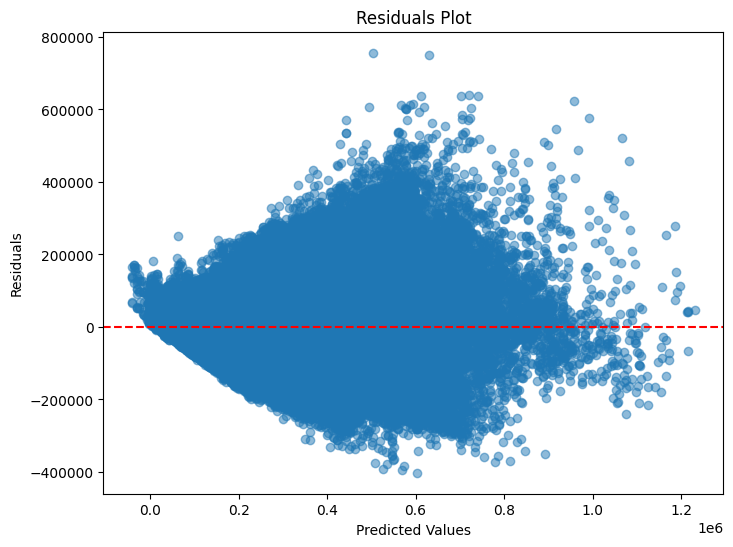

In [ ]:
# predicting + evaluating
y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE):      {mae:.2f}")
print(f"R² Score:                       {r2:.4f}")

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

## Target Evaluation Metrics
- R2-score > 0.8
- RMSE < 10% of average resale price

In [ ]:
# Average resale price
avg_price = df[target].mean()
print(f"Average Resale Price:          {avg_price:.2f}")

threshhold = 0.1 * avg_price
print(f"Threshold:                     {threshhold:.2f}")

Average Resale Price:          327065.14
Threshold:                     32706.51
